### Etiquetado Gramatical

Como primer paso importar desde wikipedia datos para realizar el etiquetado (PoS Tagging).

Codigo obtenido de: [Laboratorio 2 PLN](https://github.com/pln-fing-udelar/intropln2013-lab2/blob/master/lab_entrega2.ipynb)

In [6]:
from glob import glob
from codecs import open, BOM_UTF8 
  
def wikicorpus(words=1000000, start=0):
    s = [[]]
    i = 0
    for f in glob("tagged.es/*")[start:]:
        for line in open(f, encoding="latin-1"):
            if line == "\n" or line.startswith((
              "<doc", "</doc>", "ENDOFARTICLE", "REDIRECT",
              "Acontecimientos", 
              "Fallecimientos", 
              "Nacimientos")):
                continue
            w, lemma, tag, x = line.split(" ")
            if tag.startswith("Fp"):
                tag = tag[:3]
            elif tag.startswith("V"):  # VMIP3P0 => VMI
                tag = tag[:3]
            elif tag.startswith("NC"): # NCMS000 => NCS
                tag = tag[:2] + tag[3]
            else:
                tag = tag[:2]
            for w in w.split("_"): # Puerto_Rico
                s[-1].append((w, tag)); i+=1
            if tag == "Fp" and w == ".":
                s.append([])
            if i >= words:
                return s[:-1]

In [7]:
corpus = wikicorpus()

In [8]:
import random
elegir10 = random.sample(range(len(corpus)), int(len(corpus)*.1))
testing = [corpus[i] for i in elegir10]
training = [corpus[i] for i in range(len(corpus)) if i not in elegir10]

In [9]:
from nltk.tag import BigramTagger, DefaultTagger, RegexpTagger, TrigramTagger, UnigramTagger

patterns = [
      (r'(\w*ado$)|(\w*ada$)|(\w*ido$)|(\w*ida$)|(\w*ito$)|(\w*ita$)|(\w*ota$)|(\w*ote$)|(\w*ense$)|(\w+oso$)|(\w+osa$)', 'A'), # adjetivos
      (r'(\w*ico$)|(\w*aco$)|(\w*aca$)|(\w*ble$)|(\w*cida$)|(\w*dero$)|(\w*dera$)|(\w*dizo$)|(\w*diza$)|(\w*eco$)', 'A'),      
      (r'(\w*ados$)|(\w*adas$)|(\w*idos$)|(\w*idas$)|(\w*itos$)|(\w*itas$)|(\w*otas$)|(\w*otes$)|(\w*enses$)|(\w+osos$)|(\w+osas$)', 'A'), # adjetivos en plural
      (r'(\w*icos$)|(\w*acos$)|(\w*acas$)|(\w*bles$)|(\w*cidas$)|(\w*deros$)|(\w*deras$)|(\w*dizos$)|(\w*dizas$)|(\w*ecos$)', 'A'),
      (r'(\w*cion$)|(\w*azgo$)|(\w*bilidad$)|(\w*encia$)|(\w*ería$)', 'N'), # nombre 
      (r'(\w*aje$)|(\w*al$)|(\w*algia$)|(\w*ancia$)|(\w*anza$)|(\w*ato$)|(\w+era$)|(\w*ero$)|(\w*tud$)', 'N'),
      (r'(\w*dad$)|(\w*dor$)|(\w*dora$)|(\w*eza$)|(\w*ismo$)', 'N'),
      (r'(\w*ciones$)|(\w*azgos$)|(\w*bilidades$)|(\w*encias$)|(\w*erías$)', 'N'), # nombres en plural
      (r'(\w*ajes$)|(\w*ales$)|(\w*algias$)|(\w*ancias$)|(\w*anzas$)|(\w*atos$)|(\w+eras$)|(\w*eros$)|(\w*tudes$)', 'N'),
      (r'(\w*dades$)|(\w*dores$)|(\w*doras$)|(\w*ezas$)|(\w*ismos$)', 'N'),
      (r'(\w*ar$)|(\w*er$)|(\w*ir$)|(\w*mos$)', 'V'), # verbos
      (r'(\w*ando$)|(\w*endo$)', 'V'),                # gerundio
      (r'.*', None)                                   # none (default)
]

regexp_tagger = RegexpTagger(patterns)

dt = DefaultTagger('N')

ut = UnigramTagger(train=training, backoff=regexp_tagger)
bt = BigramTagger(train=training, backoff=ut)
tt = TrigramTagger(train=training, backoff=bt)

### Wordnet

Importar datos de Wordnet para utilizar sinónimos:

In [10]:
from nltk.corpus import WordNetCorpusReader
import nltk.data
wncr = WordNetCorpusReader('wordnet_spa', [])

In [11]:
from nltk import word_tokenize
from nltk.stem.snowball import SpanishStemmer
import operator
from scipy.spatial.distance import cosine


ss = SpanishStemmer()

def tokenize_w_synon(oracion):
    res = []
    for (palabra, tag) in tt.tag(word_tokenize(oracion)):
        if tag != None:
            if tag.startswith(u'N'):
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(palabra, wncr.NOUN)]))
            elif tag.startswith(u'A'):
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(palabra, wncr.ADJ)]))
            elif tag.startswith(u'V'):
                res.append(ss.stem(palabra))
    return res

def tokenize(oracion):
    res = []
    for (palabra, tag) in tt.tag(word_tokenize(oracion)):
        if tag != None:
            res.append(tag)
            if tag.startswith(u'V'):
                res.append(ss.stem(palabra))
    return res

def imprimir_similares(vectores, similar, similitud):
    cant_top = 5
    mostrados = set()
    for top_i, valor_similitud in sorted(similitud.iteritems(), key=operator.itemgetter(1), reverse=True):
        if similar[top_i] in mostrados and similar[similar[top_i]] == top_i:
            continue
        mostrados.add(top_i)
        print len(mostrados), (oraciones[top_i], oraciones[similar[top_i]], valor_similitud)
        if len(mostrados) >= cant_top:
            break


In [12]:
# Cargado de letras en una lista:
import json
from nltk.tokenize import sent_tokenize
f = json.load(open('data/clean/works.json'))
oraciones=[]
oraciones_works = []
years=[]
for w in f:
    if len(w['lyric']):
        texto = ''
        for verso in w['lyric']:
            for linea in verso:
                texto += unicode(linea.replace('\r\n','') + ' ')
        oraciones.append(texto)
        oraciones_works.append(w['id'])
        if (len(w['date'])):
            years.append(int(w['date'][2]))
        else:
            years.append(0)


### Cálculo de Similitud 

Generado de vectores para las letras utilizando Tf-Idf, luego cálculo de similtudes entre los vectores

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
transf = TfidfVectorizer(encoding=u'unicode', tokenizer=tokenize)#, strip_accents=u'unicode')
vectores = transf.fit_transform(oraciones)

In [14]:
import numpy as np
import itertools
similitud = {}
v = (vectores * vectores.T).A
v[np.diag_indices_from(v)] -= 1

ignore = np.argwhere(v>0.95)
vectores_non_simil = np.delete(vectores.toarray(), ignore[:,1], 0)



#imprimir_similares(vectores_non_simil, v.argmax(axis=0), similitud)

### Clusters

Selección del valor óptimo de clusters, analizando Silhouette y Calinski-harabaz para medir que tan compactos son los clusters. Aunque hay que tener en cuenta que una mejor medida no implica que se van a obtener mejores resultados, solo que los clusters son más compactos 

ValueError: x and y must have same first dimension

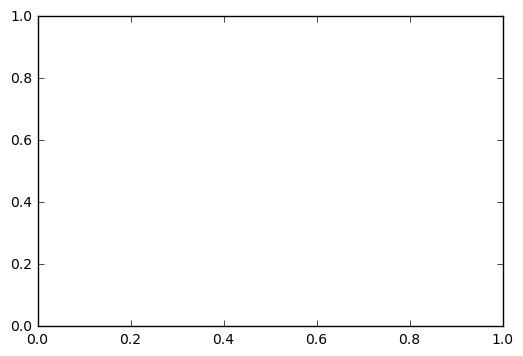

In [37]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import calinski_harabaz_score, silhouette_score
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

x = range(2,16)
kmeans_full_silhouette = []
kmeans_filtered_silhouette = []
sc_full_silhouette = []
sc_filtered_silhouette = []

kmeans_full_calinski = []
kmeans_filtered_calinski = []
sc_full_calinski = []
sc_filtered_calinski = []

for i in x:
    clusterer = KMeans(n_clusters=i, random_state=10)
    cluster_labels = clusterer.fit_predict(vectores.toarray())
    kmeans_full_calinski.append(calinski_harabaz_score(vectores.toarray(), cluster_labels))
    kmeans_full_silhouette.append(silhouette_score(vectores.toarray(), cluster_labels))

    clusterer = SpectralClustering(n_clusters=i) 
    cluster_labels = clusterer.fit_predict(vectores.toarray())
    sc_full_calinski.append(calinski_harabaz_score(vectores.toarray(), cluster_labels))
    sc_full_silhouette.append(silhouette_score(vectores.toarray(), cluster_labels))

    clusterer = KMeans(n_clusters=i, random_state=10)
    cluster_labels = clusterer.fit_predict(vectores_non_simil)
    kmeans_filtered_calinski.append(calinski_harabaz_score(vectores_non_simil, cluster_labels))
    kmeans_filtered_silhouette.append(silhouette_score(vectores_non_simil, cluster_labels))

    clusterer = SpectralClustering(n_clusters=i) 
    cluster_labels = clusterer.fit_predict(vectores_non_simil)
    sc_filtered_calinski.append(calinski_harabaz_score(vectores_non_simil, cluster_labels))
    sc_filtered_silhouette.append(silhouette_score(vectores_non_simil, cluster_labels))

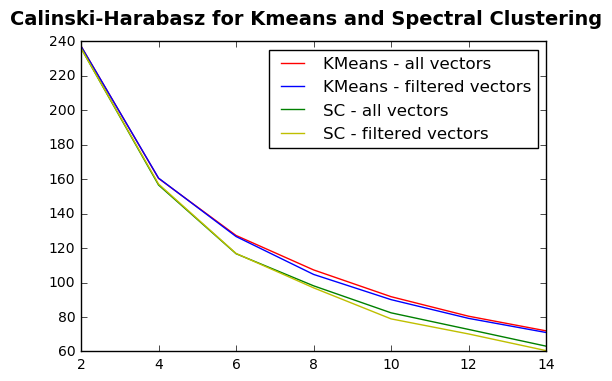

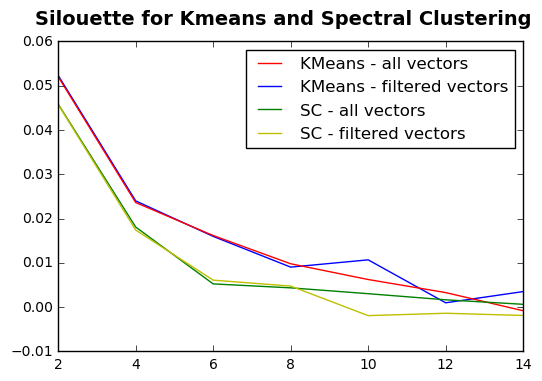

In [48]:
plt.figure(1)  
 
p1, = plt.plot(x, kmeans_full_calinski, color='r')
p2, = plt.plot(x, kmeans_filtered_calinski, color='b')
p3, = plt.plot(x, sc_full_calinski, color='g')
p4, = plt.plot(x, sc_filtered_calinski, color='y')
plt.legend([p1, p2, p3, p4], ["KMeans - all vectors", "KMeans - filtered vectors", "SC - all vectors", "SC - filtered vectors"])
plt.suptitle(("Calinski-Harabasz for Kmeans and Spectral Clustering"), fontsize=14, fontweight='bold')

plt.figure(2)  
p2, = plt.plot(x, kmeans_full_silhouette, color='b')
p1, = plt.plot(x, kmeans_filtered_silhouette, color='r')
p3, = plt.plot(x, sc_full_silhouette, color='g')
p4, = plt.plot(x, sc_filtered_silhouette, color='y')
plt.legend([p1, p2, p3, p4], ["KMeans - all vectors", "KMeans - filtered vectors", "SC - all vectors", "SC - filtered vectors"])
plt.suptitle(("Silouette for Kmeans and Spectral Clustering"), fontsize=14, fontweight='bold')

4 -0.0985378720063 3 0.5
5 -0.0153535060337 3 0.6
3 0.107442341181 3 0.7
2 0.314448266901 3 1
4 -0.0830745996366 4 0.5
4 0.0217752675734 4 0.6
2 0.108382669351 4 0.7
2 0.314448266901 4 1


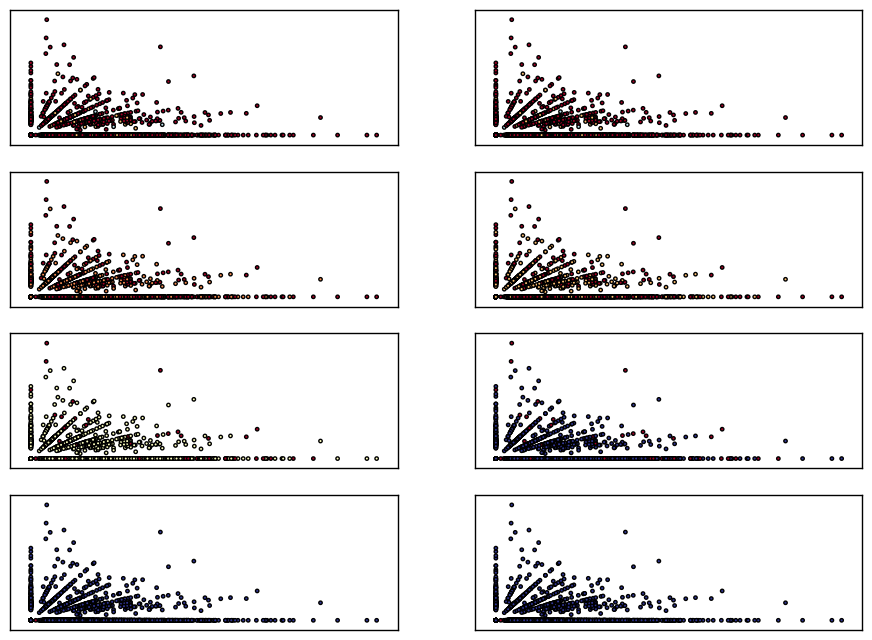

In [224]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

fig, axes = plt.subplots(4, 2, figsize=(22, 8), subplot_kw={'xticks': (), 'yticks': ()})

scaler = StandardScaler(with_mean=False)
scaler.fit(vectores)
X_scaled = vectores_non_simil
for i, min_samples in enumerate([3, 4]):
    for j, eps in enumerate([0.5, 0.6, 0.7, 1]):
        clustering = DBSCAN(min_samples=min_samples, eps=eps)
        clusters = clustering.fit_predict(X_scaled)
        axes[j, i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=plt.cm.get_cmap('RdYlBu'), s=6)
        if len(set(clusters)) > 1:
            print(len(set(clusters)), silhouette_score(X_scaled, clusters), min_samples, eps)


Generación de Clusters utilizando Spectral Clustering de los vectores recién calculados

In [10]:
from sklearn.cluster import SpectralClustering
n_clusters = 8 ### Number of clusters
clustering = SpectralClustering(n_clusters=n_clusters) # ? n_clusters
#clusters = clustering.fit_transform(vectores.toarray())
#predicciones = clustering.fit_predict(vectores.toarray())
predicciones = clustering.fit_predict(vectores_non_simil)
print predicciones

[ 6  4  6 ..., 12 11  4]


In [11]:
clusters = []
for i in range(clustering.n_clusters):
    clusters.append([])
for i, c in zip(range(len(predicciones)), predicciones):
    clusters[c].append(i)
for i, cluster in zip(range(1, len(clusters)+1), clusters):
    print i, len(cluster), '\n'

1 [678, 747, 1578, 2083, 2588, 2617, 2619, 2643, 2652, 2715, 2828, 2864, 3022, 3046, 3181, 3238, 3507, 3512, 3523, 3524, 3525, 3526, 3533, 3543, 3549, 3572, 3585, 3591, 3599, 3614, 3621, 3643, 3667, 3672, 3739, 3775, 3814, 3816, 3817, 3826, 3827, 3828, 3835, 3837, 3880, 3890, 3891, 3916, 3949, 4058, 4059, 4067, 4086, 4107, 4117, 4142, 4160, 4166, 4179, 4183, 4186, 4189, 4197, 4216, 4219, 4223, 4263, 4265, 4268, 4269, 4298, 4301, 4336, 4337, 4374, 4380, 4419, 4433, 4456, 4465, 4487, 4505, 4517, 4536, 4537, 4574, 4632, 4641, 4673, 4734, 4772, 4775, 4776, 4778, 4779, 4780, 4781, 4782, 4783, 4804, 4806, 4810, 4811, 4812, 4815, 4820, 4821, 4827, 4828, 4841, 4858, 4872, 4888, 4936, 4942, 4943, 4945, 5027, 5032, 5087, 5090, 5099, 5111, 5112, 5113, 5116, 5128, 5130, 5154, 5168, 5204, 5206, 5209, 5219, 5263, 5270, 5272, 5277, 5279, 5285, 5288, 5289, 5389, 5399, 5400, 5421, 5424, 5434, 5441, 5574, 5582, 5584, 5597, 5605] 

2 [31, 77, 97, 98, 103, 105, 143, 173, 194, 208, 273, 276, 277, 279, 298,

In [ ]:
print oraciones[9]
print "-----------"
print oraciones[28]

Rechiflado en mi tristeza, te evoco y veo que has sido en mi pobre vida paria sólo una buena mujer. Tu presencia de bacana puso calor en mi nido, fuiste buena, consecuente, y yo sé que me has querido como no quisiste a nadie, como no podrás querer. Se dio el juego de remanye cuando vos, pobre percanta, gambeteabas la pobreza en la casa de pensión. Hoy sos toda una bacana, la vida te ríe y canta, Ios morlacos del otario los jugás a la marchanta como juega el gato maula con el mísero ratón. Hoy tenés el mate lleno de infelices ilusiones, te engrupieron los otarios, las amigas y el gavión; la milonga, entre magnates, con sus locas tentaciones, donde triunfan y claudican milongueras pretensiones, se te ha entrado muy adentro en tu pobre corazón. Nada debo agradecerte, mano a mano hemos quedado; no me importa lo que has hecho, lo que hacés ni lo que harás... Los favores recibidos creo habértelos pagado y, si alguna deuda chica sin querer se me ha olvidado, en la cuenta del otario que tenés 

### Clusters II

Clustering utilizando un nuevo PoS Tagger, basado en Kmeans

In [ ]:

from pattern.es     import tag
from pattern.vector import Document, Model, KMEANS, stem

docs = []
i = 0
j = 0
for s in oraciones:
    v = tag(s)
    res = []
    for (word, pos) in tag(s):
        if pos != None:
            '''if pos == 'NN':
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(word, wncr.NOUN)]))
            elif pos == 'JJ':
                res += list(set([synset.name().split(".")[0] for synset in wncr.synsets(word, wncr.ADJ)]))
            elif pos == 'VB':
                res.append(ss.stem(word))'''
            res.append(pos)
            if pos == 'VB':
                res.append(ss.stem(word))
    if i not in ignore[:,1]:
        docs.append(Document(res, name=j))
        j+=1
    i+=1

In [ ]:
from pattern.vector import COSINE
m = Model(docs)
c = m.cluster(method=KMEANS, k=n_clusters, distance=COSINE)

In [ ]:
# Número de letras por cluster
for i, cluster in zip(range(1, len(c)+1), c):
    #print i, [d.name for d in cluster], '\n'
    print i, len(cluster), '\n'

1 315 

2 152 

3 451 

4 312 

5 288 

6 321 

7 282 

8 295 

9 477 

10 474 

11 614 

12 89 

13 455 

14 415 

15 685 



### Visualizacion de los resultados

Reducción de dimansionalidad utilizando T-SNE, para obtener representacion en 2 dimensiones. 


In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=3)
#data2d = tsne.fit_transform(vectores.toarray())
data2d = tsne.fit_transform(vectores_non_simil )

### Clusters utilizando Spectral Clustering

/home/andres/projects/tango-data/env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


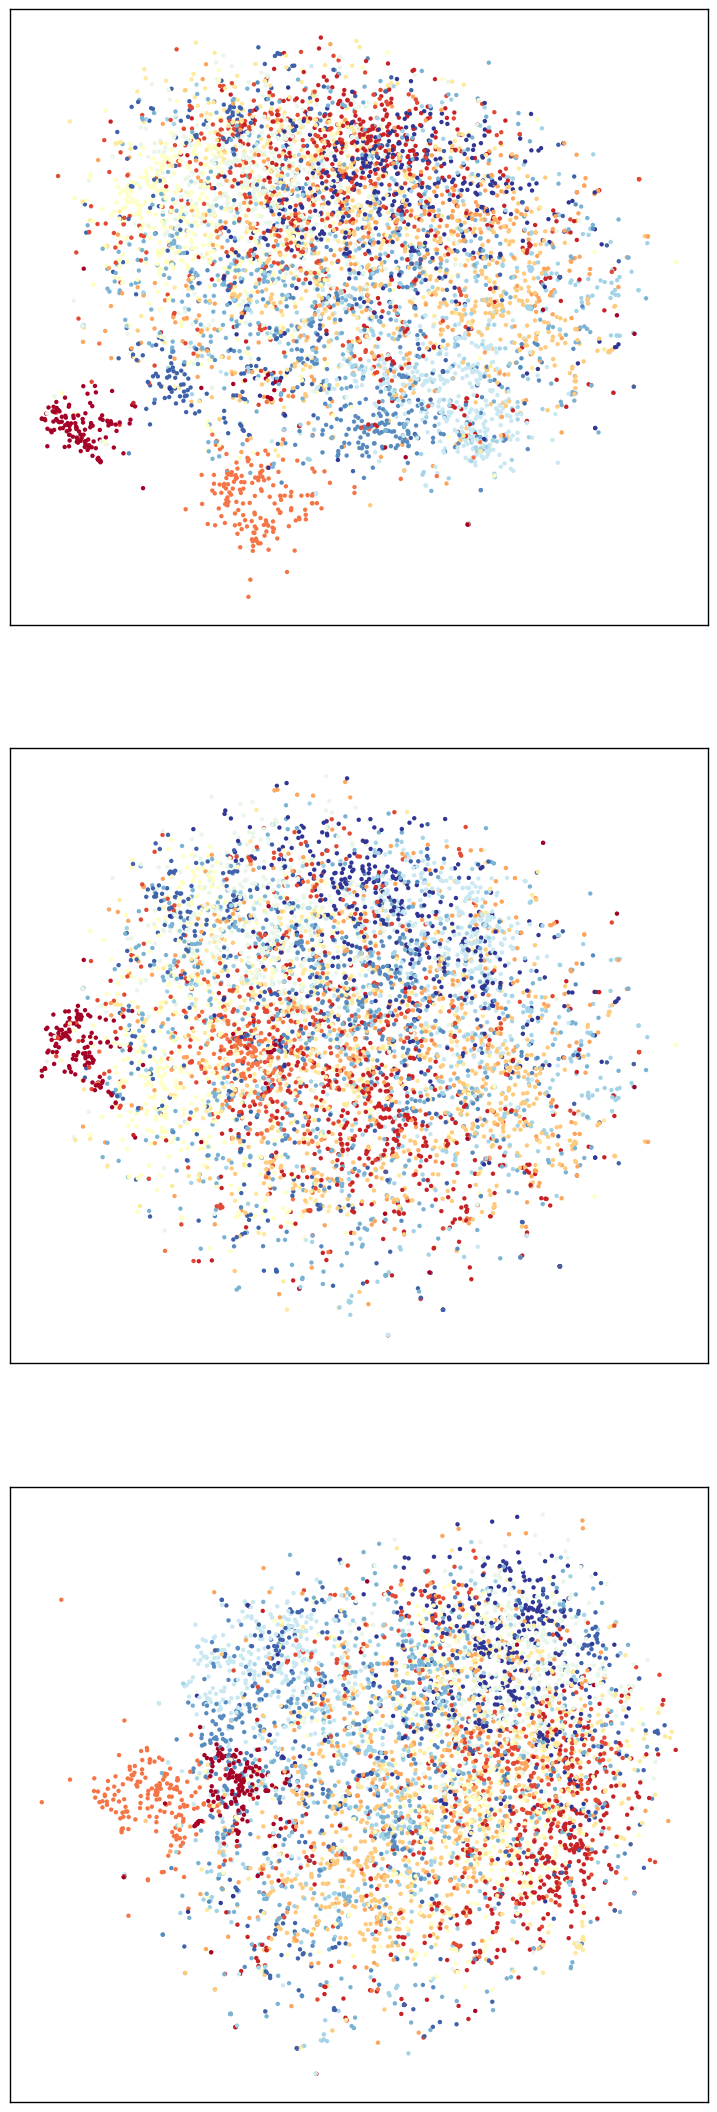

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

fig, axes = plt.subplots(3, 1, figsize=(9, 27), subplot_kw={'xticks': (), 'yticks': ()})
plt.figure(figsize=(9,9))
axes[0].scatter(data2d[:,0], data2d[:,1], c=predicciones, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 
axes[1].scatter(data2d[:,0], data2d[:,2], c=predicciones, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 
axes[2].scatter(data2d[:,1], data2d[:,2], c=predicciones, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 

#plt.figure(figsize=(10,10))
#plt.scatter(data2d[:,0], data2d[:,1], c=predicciones, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 


### Clusters utilizando Kmeans

In [ ]:
pred = [0] * len(predicciones)

for i, cluster in zip(range(1, len(c)+1), c):
    for j in cluster:
        pred[j.name] = i


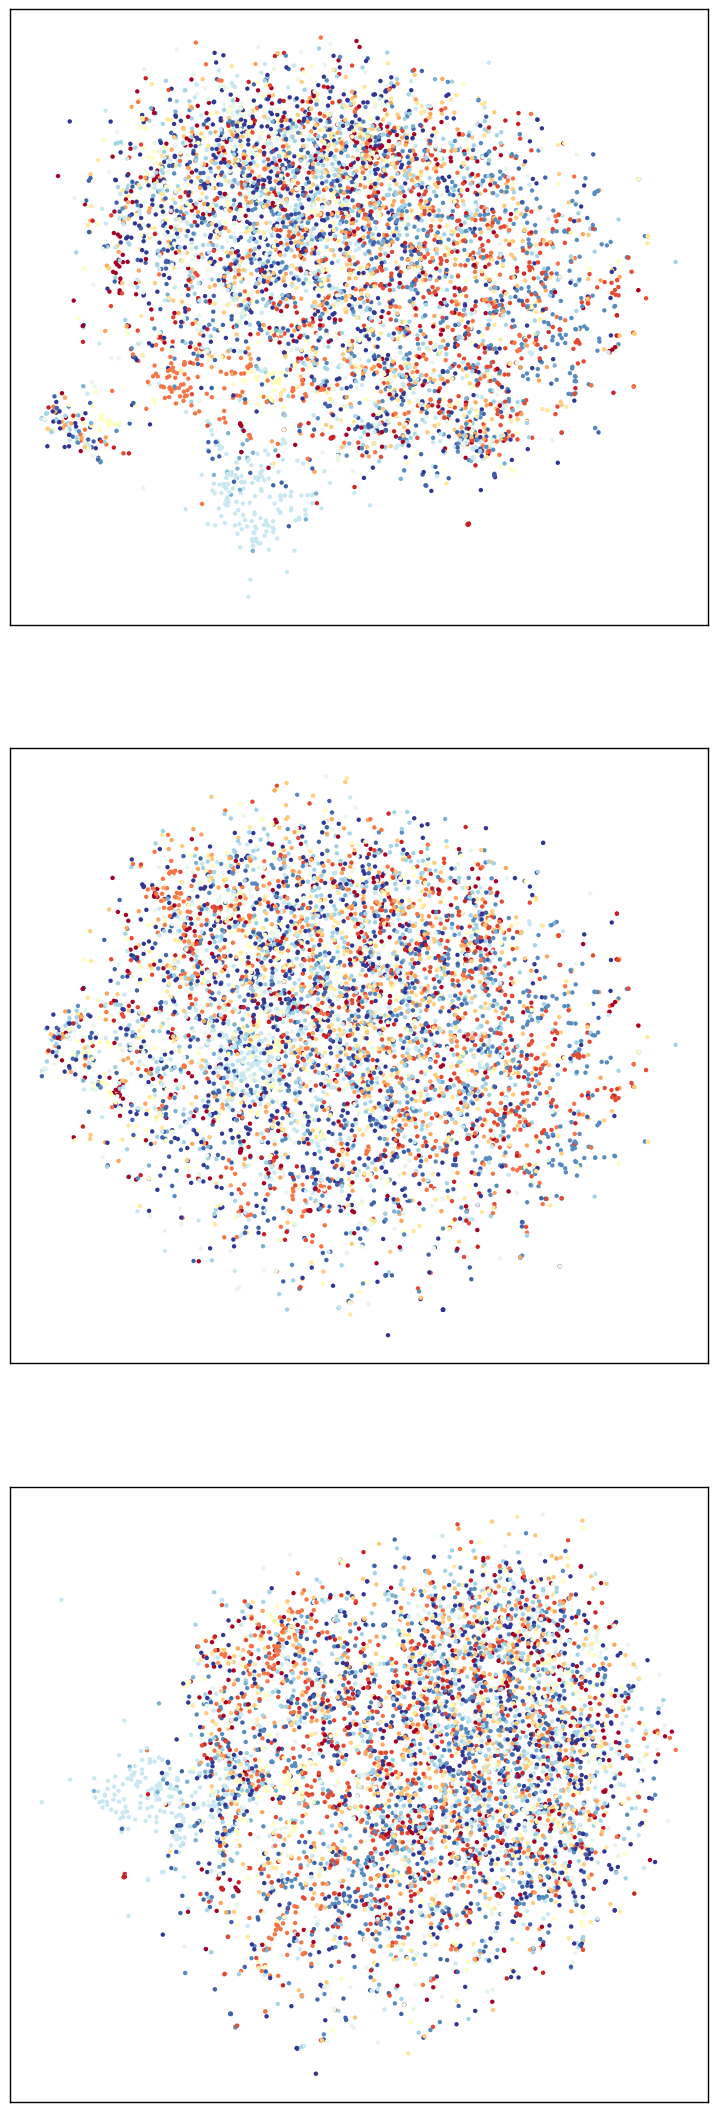

In [ ]:

fig, axes = plt.subplots(3, 1, figsize=(9, 27), subplot_kw={'xticks': (), 'yticks': ()})
plt.figure(figsize=(9,9))
axes[0].scatter(data2d[:,0], data2d[:,1], c=pred, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 
axes[1].scatter(data2d[:,0], data2d[:,2], c=pred, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 
axes[2].scatter(data2d[:,1], data2d[:,2], c=pred, s=10, marker='o', linewidth=0, cmap=plt.cm.get_cmap('RdYlBu')) 


For n_clusters = 8 The average silhouette_score is : 0.00904281114761


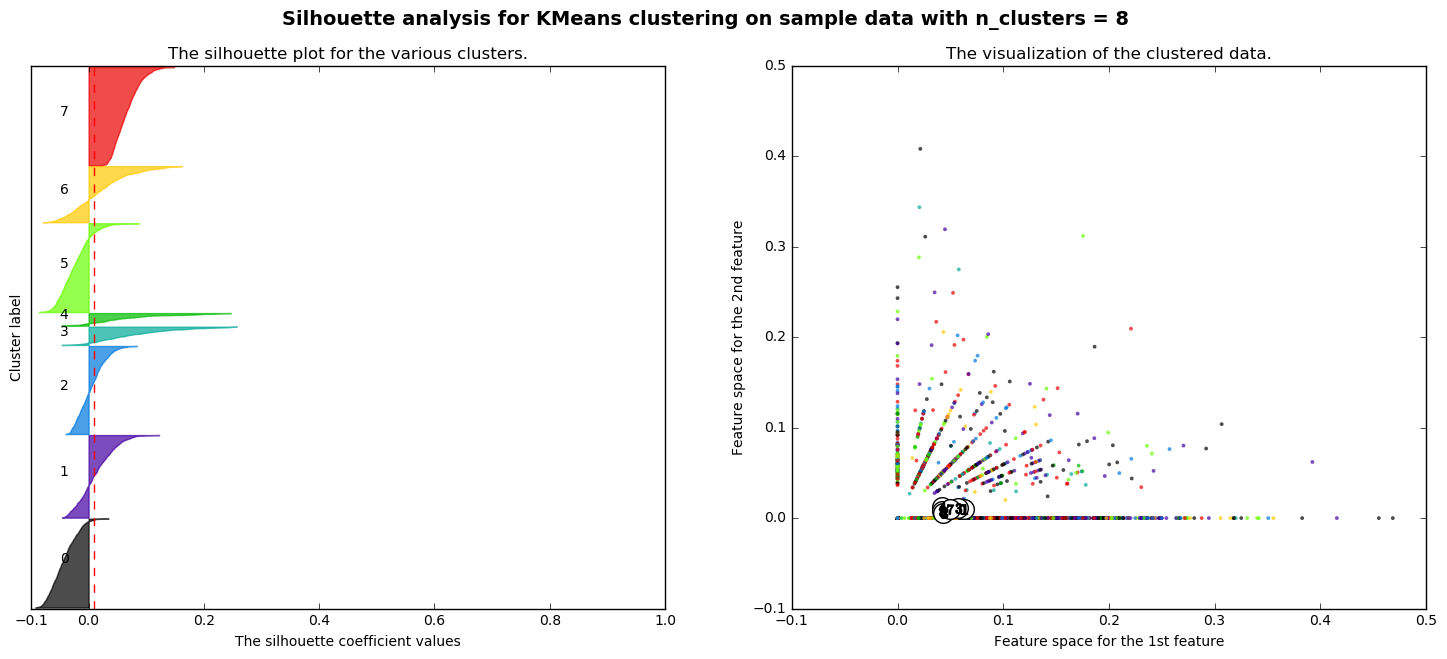

For n_clusters = 12 The average silhouette_score is : 0.000985035420004


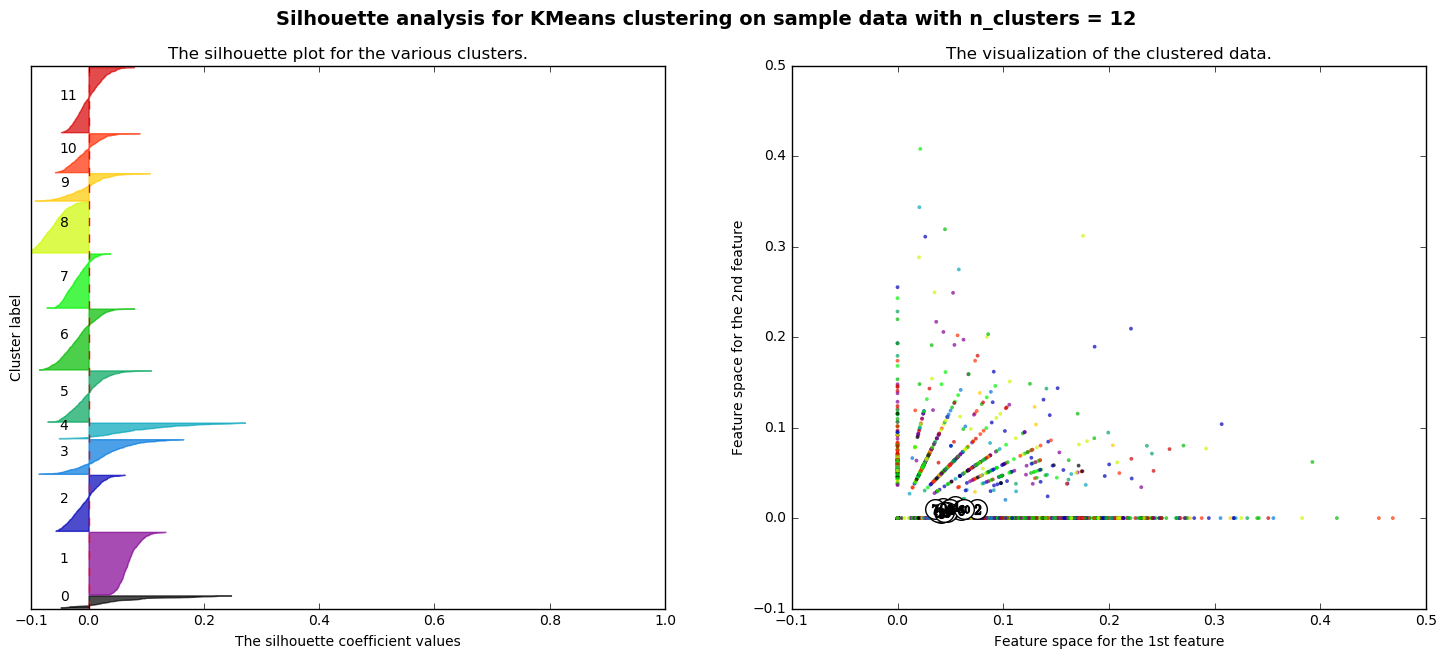

For n_clusters = 16 The average silhouette_score is : 0.00774339367089


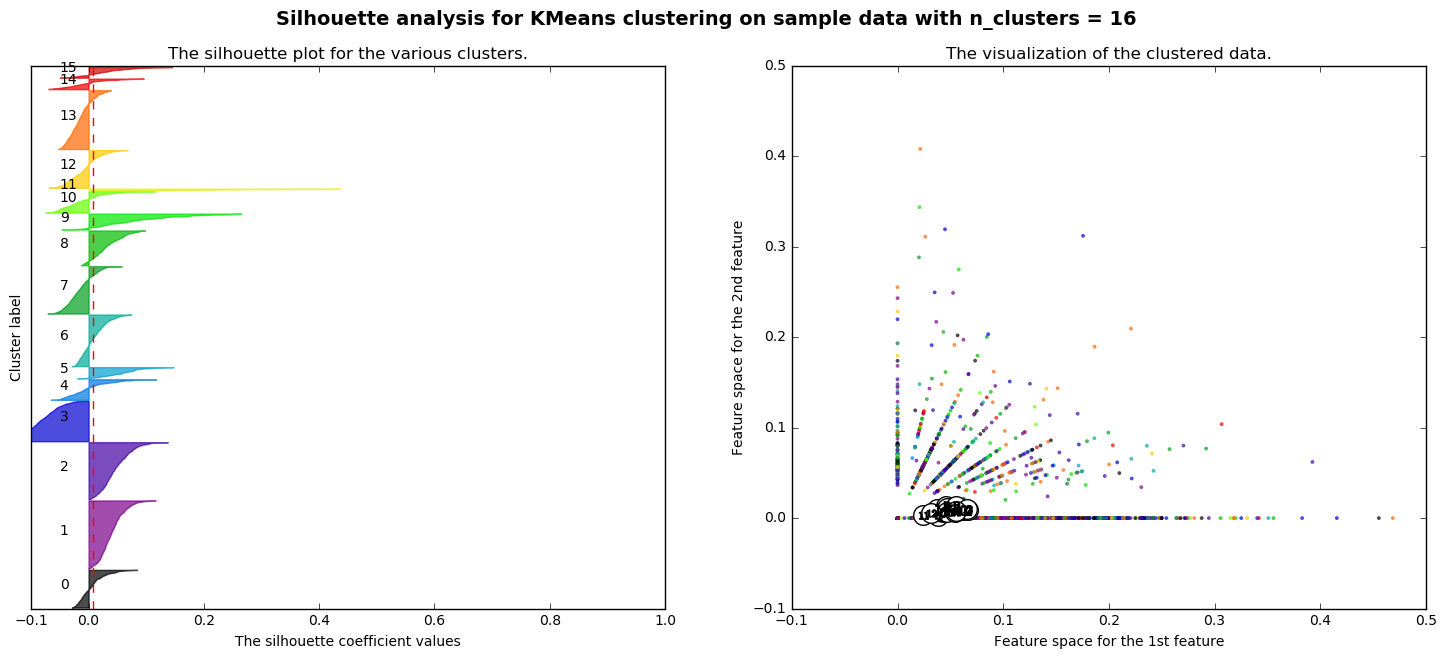

For n_clusters = 24 The average silhouette_score is : -0.00298101420487


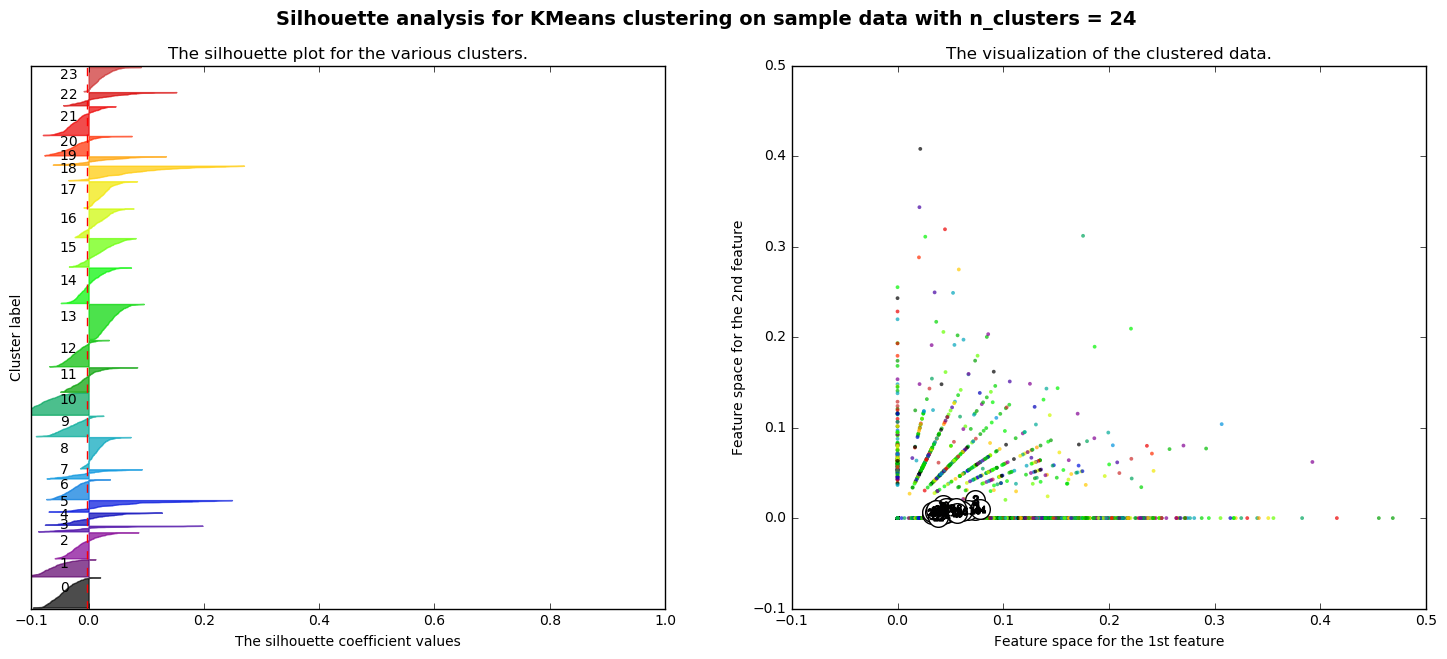

In [35]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
range_n_clusters = [8, 12, 16, 24]
X = vectores.toarray()
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print "For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

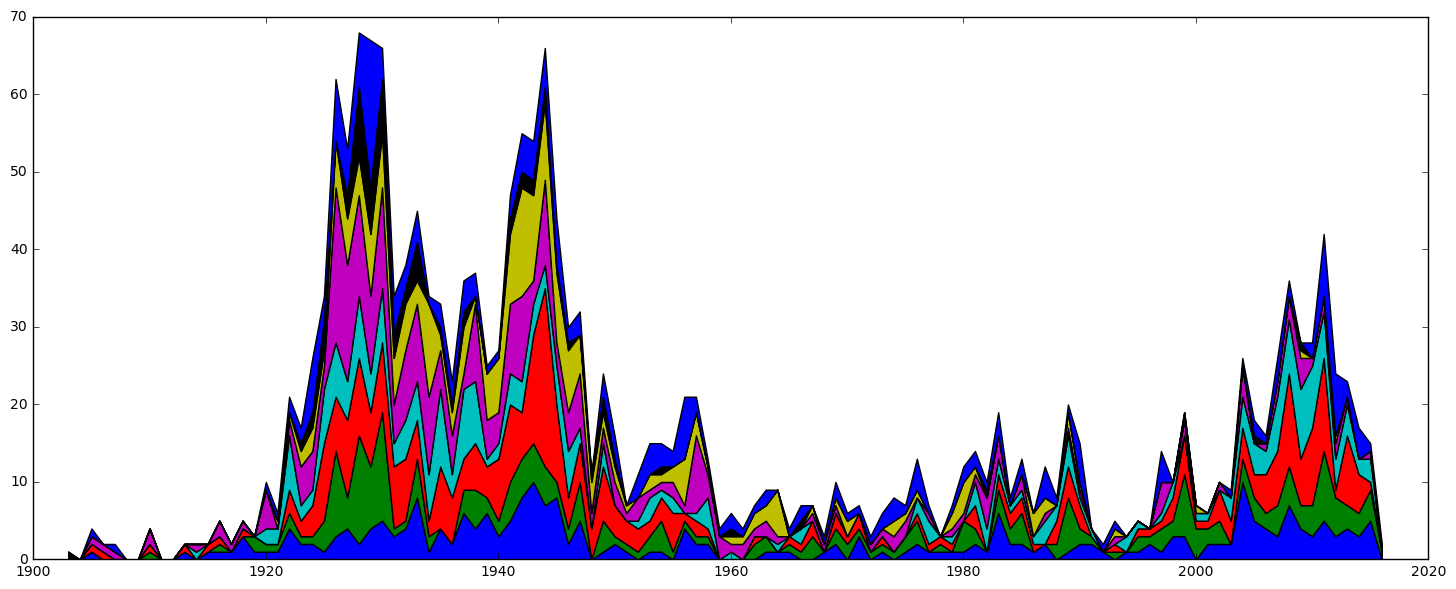

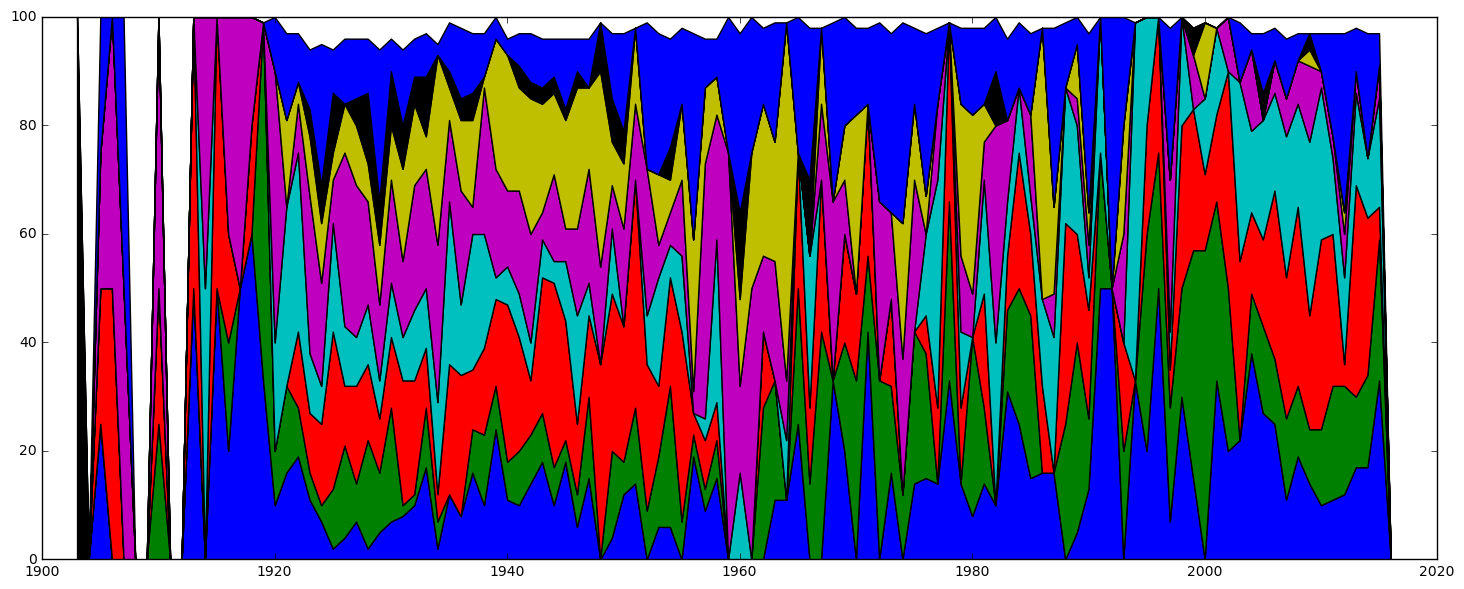

In [217]:


all_years = set(years) - set([0])
numb_yers = (max(all_years) - min(all_years))

values = [[]] * (n_clusters)
values_p = [[]] * (n_clusters)
for i in range(n_clusters):
    values[i] = [0] * (numb_yers+1)
    values_p[i] = [0] * (numb_yers+1)
    
for current_year, current_cluster in zip(years, predicciones):
    if current_year:
        values[current_cluster][current_year-min(all_years)] += 1
            
fig, ax = plt.subplots()
ax.stackplot(range(min(all_years), max(all_years)+1), values)
fig.set_size_inches(18, 7)

for i in range(numb_yers):
    total = 0
    for j in range(n_clusters):
        total += values[j][i]
    for j in range(n_clusters):
        if total:
            values_p[j][i] = values[j][i]*100/total            
            
fig2, ax2 = plt.subplots()
ax2.stackplot(range(min(all_years), max(all_years)+1), values_p)
fig2.set_size_inches(18, 7)

In [31]:
works = f
mejores = ["De barro", "Sur", "Mano a mano", u"Cafetín de Buenos Aires", "Las cuarenta", u"Garúa", "Balada para mi muerte"
          "Bocha", "Esta ciudad", "Sexto piso"]
#Jorge Alorsa:                        Ezeiza #Falta
#Raimundo Rosales:                    Ultimo Tango #Falta
peores = ["La cieguita", u"La cumparsita [Matos Rodríguez]", "Cucusita", "Gurisa", "El bazar de los juguetes", "El tarta"]
gastados = ["Naranjo en flor", "Los mareados", "Malena", "El choclo", "Nostalgias", "Balada para un loco"]

mejores_ret = []
peores_ret = []
gastados_ret = []
for w in works:
    if w['title'] in mejores:
        if len(w['lyric']):
            ret =[]
            for i in  v[w['id']].argsort()[-2:][::-1]:
                ret.append(works[oraciones_works[i]])
            mejores_ret.append(ret)
        else:
            print "no lyric: %d" % w['id']
    if w['title'] in peores:
        if len(w['lyric']):
            ret =[]
            for i in  v[w['id']].argsort()[-2:][::-1]:
                ret.append(works[oraciones_works[i]])
            peores_ret.append(ret)
        else:
            print "no lyric: %d" % w['id']
            
    if w['title'] in gastados:
        if len(w['lyric']):
            ret =[]
            for i in  v[w['id']].argsort()[-2:][::-1]:
                ret.append(works[oraciones_works[i]])
            gastados_ret.append(ret)
        else:
            print "no lyric: %d" % w['id']


no lyric: 288


In [32]:
for i in gastados_ret:
    print "----"
    for k in i:
        print k['external_id']['todotango']

----
http://www.todotango.com/musica/tema/3572/No-cantes-victoria/
http://www.todotango.com/musica/tema/3806/Como-todas/
----
http://www.todotango.com/musica/tema/1210/Campana-de-plata/
http://www.todotango.com/musica/tema/3124/Sos-de-la-Quema/
----
http://www.todotango.com/musica/tema/4274/Espianta-Gregorio/
http://www.todotango.com/musica/tema/1136/Arrabalera/
----
http://www.todotango.com/musica/tema/66/A-Homero/
http://www.todotango.com/musica/tema/2460/Buenos-Aires-[b]/
----
http://www.todotango.com/musica/tema/100/Margot/
http://www.todotango.com/musica/tema/7735/A-vos-te-arrancaron-verde/
----
http://www.todotango.com/musica/tema/5941/De-mi-tierra-[b]/
http://www.todotango.com/musica/tema/192/Balada-para-un-loco/
